Целью данного проекта является прогнозирование уровня популярности видеоигр на основе их метаданных.

Для каждой игры из датасета (включающего такие признаки, как название, дата релиза, цена, возрастной рейтинг, жанры, теги, категории, поддерживаемые платформы, разработчики, издатели и другие характеристики) требуется определить её класс популярности, закодированный как:

* 0 — низкая популярность,
* 1 — средняя популярность,
* 2 — высокая популярность.

Задача представляет собой многоклассовую классификацию

Модель может быть использована для:
* оценки потенциального успеха игры до её релиза
* рекомендаций разработчикам по выбору жанров, тегов и платформ


# Импорт

In [ ]:
from enum import IntEnum
from typing import Final

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, FunctionTransformer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

import lightgbm as lgb

import kagglehub

# Подготовка DataFrame

In [ ]:
DATASET_REF: Final[str] = 'fronkongames/steam-games-dataset'
CSV_FILENAME: Final[str] = 'games.json'
JSON_PATH: Final[str] = f'{kagglehub.dataset_download(DATASET_REF)}/{CSV_FILENAME}'

СOLUMN_NAME_DICT: Final = {
    'name': 'Name',
    'release_date': 'Release date',
    'required_age': 'Required age',
    'price': 'Price',
    'dlc_count': 'DLC count',
    'detailed_description': 'Detailed description',
    'about_the_game': 'About the game',
    'short_description': 'Short description',
    'reviews': 'Reviews',
    'header_image': 'Header image',
    'website': 'Website',
    'support_url': 'Support url',
    'support_email': 'Support email',
    'windows': 'Windows',
    'mac': 'Mac',
    'linux': 'Linux',
    'metacritic_score': 'Metacritic score',
    'metacritic_url': 'Metacritic url',
    'achievements': 'Achievements',
    'recommendations': 'Recommendations',
    'notes': 'Notes',
    'supported_languages': 'Supported languages',
    'full_audio_languages': 'Full audio languages',
    'packages': 'Packages',
    'developers': 'Developers',
    'publishers': 'Publishers',
    'categories': 'Categories',
    'genres': 'Genres',
    'screenshots': 'Screenshots',
    'movies': 'Movies',
    'user_score': 'User score',
    'score_rank': 'Score rank',
    'positive': 'Positive',
    'negative': 'Negative',
    'estimated_owners': 'Estimated owners',
    'average_playtime_forever': 'Average playtime forever',
    'average_playtime_2weeks': 'Average playtime two weeks',
    'median_playtime_forever': 'Median playtime forever',
    'median_playtime_2weeks': 'Median playtime two weeks',
    'peak_ccu': 'Peak CCU',
    'tags': 'Tags',
}

FEATURE_COLUMNS: Final = [
    'Name',
    'Release date',
    'Required age',
    'Price',
    'Detailed description',
    'About the game',
    'Short description',
    'Website',
    'Support url',
    'Support email',
    'Windows',
    'Mac',
    'Linux',
    'Notes',
    'Supported languages',
    'Full audio languages',
    'Developers',
    'Publishers',
    'Categories',
    'Genres',
    'Tags',
]

TARGET_SOURCE_COLUMN: Final[str] = "Estimated owners"
TARGET: Final[str] = 'Popularity class'

Using Colab cache for faster access to the 'steam-games-dataset' dataset.


In [ ]:
class PopularityClass(IntEnum):
    UNPOPULAR = 0
    MODERATE = 1
    POPULAR = 2

def map_to_popularity(owner_range: str) -> int:
    if owner_range == '0 - 0':
        return PopularityClass.UNPOPULAR
    elif owner_range == '0 - 20000':
        return PopularityClass.MODERATE
    else:
        return PopularityClass.POPULAR

In [ ]:
# Небольшой костыль, т.к. исходынй файл csv кривой

def convert_dict_to_string(dict_object):
    if len(dict_object) == 0:
        return np.nan
    key_list = list(dict_object.keys())
    keys_string = ','.join(key_list)
    return keys_string

def read_convert_json_dataset():
    _df = pd.read_json(JSON_PATH)
    _df = _df.T
    _df['AppID'] = _df.index
    _df.rename(columns=СOLUMN_NAME_DICT, inplace=True)

    for col in _df.columns.values:
        if isinstance(_df.loc[546560][col], dict):
            _df[col] = _df[col].apply(lambda entries: convert_dict_to_string(entries))
        if isinstance(_df.loc[546560][col], list):
            if isinstance(_df.loc[546560][col][0], str):
                _df[col] = _df[col].apply(lambda entries: ','.join(entries))
    _df = _df.reset_index().set_index('AppID')
    return _df

df_full = read_convert_json_dataset()

In [ ]:
df = (
    df_full[FEATURE_COLUMNS + [TARGET_SOURCE_COLUMN]]
    .copy()
    .assign(**{TARGET: lambda x: x[TARGET_SOURCE_COLUMN].map(map_to_popularity)})
    .drop(columns=TARGET_SOURCE_COLUMN)
)

df['Release date'] = pd.to_datetime(df['Release date'], errors='coerce')
df['Release month'] = df['Release date'].dt.month
df['Release month_cos'] = np.cos(2 * np.pi * df['Release date'].dt.month / 12)
df['Release month_sin'] = np.sin(2 * np.pi * df['Release date'].dt.month / 12)

df['Required age'] = (
    pd.to_numeric(df['Required age'], errors='coerce')
    .fillna(0)
    .astype('Int64')
)

df['Price'] = pd.to_numeric(df['Price'], errors='coerce').astype('Float64')

os_columns = ['Windows', 'Mac', 'Linux']
df[os_columns] = df[os_columns].astype('boolean')

text_columns = [
    'Website', 'Support url', 'Support email', 'Notes',
    'Supported languages', 'Full audio languages',
    'Developers', 'Publishers', 'Categories', 'Genres', 'Tags'
]

df[text_columns] = (
    df[text_columns]
    .replace('', np.nan)
    .astype('object')
)

# Общая информация о датасете

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111452 entries, 20200 to 3183790
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Name                  111452 non-null  object        
 1   Release date          111321 non-null  datetime64[ns]
 2   Required age          111452 non-null  Int64         
 3   Price                 111452 non-null  Float64       
 4   Detailed description  111452 non-null  object        
 5   About the game        111452 non-null  object        
 6   Short description     111452 non-null  object        
 7   Website               46458 non-null   object        
 8   Support url           50815 non-null   object        
 9   Support email         92444 non-null   object        
 10  Windows               111452 non-null  boolean       
 11  Mac                   111452 non-null  boolean       
 12  Linux                 111452 non-null  boolean       
 13 

# Распределение классов популярности

,Count,Percentage (%)
Popularity class,,
0,22091,19.82
1,70206,62.99
2,19155,17.19


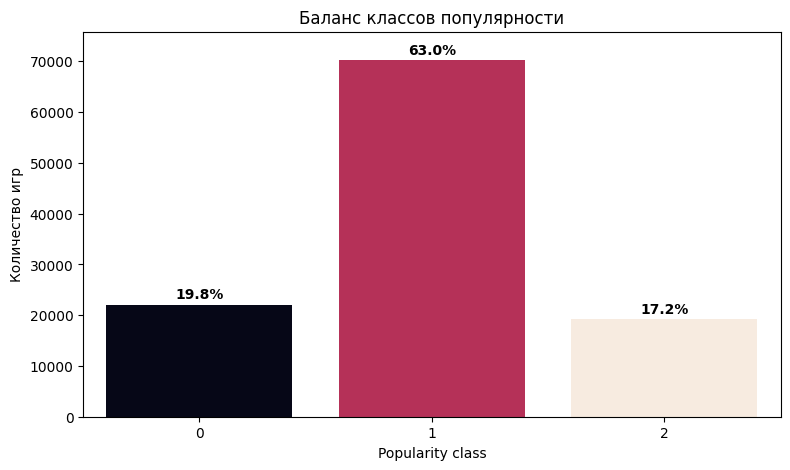

In [ ]:
pop_dist = df['Popularity class'].value_counts().sort_index()
total = len(df)
pop_pct = (pop_dist / total) * 100

dist_df = pd.DataFrame({
    'Count': pop_dist,
    'Percentage (%)': pop_pct.round(2)
})
display(dist_df)

plt.figure(figsize=(9, 5))
ax = sns.barplot(
    x=pop_dist.index,
    y=pop_dist.values,
    hue=pop_dist.index,
    palette='rocket',
    legend=False
)

for i, (count, pct) in enumerate(zip(pop_dist.values, pop_pct)):
    ax.text(i, count + total * 0.005, f'{pct:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Баланс классов популярности')
plt.xlabel('Popularity class')
plt.ylabel('Количество игр')
plt.ylim(0, pop_dist.max() * 1.08)
plt.show()

Распределение классов популярности сильно несбалансировано:

1. Класс 1 (средняя популярность) — доминирует: 63.0% всех игр.
2. Класс 0 (низкая популярность) — 19.8%.
3. Класс 2 (высокая популярность) — 17.2%.

**Вывод**: Модель, обученная на таких данных без учёта дисбаланса, будет склонна предсказывать класс 1 с высокой точностью, но плохо распознавать редкие, но важные классы (особенно «высокопопулярные» игры).

# Анализ количественных данных

In [ ]:
numeric_cols = ['Release month', 'Required age', 'Price', 'Popularity class']

In [ ]:
display(df[numeric_cols].describe(include='all'))

,Release month,Required age,Price,Popularity class
count,111321.000000,111452.0,111452.0,111452.000000
mean,6.560838,0.254208,7.061568,0.973657
std,3.479298,2.035653,12.563246,0.607773
min,1.000000,0.0,0.0,0.000000
25%,3.000000,0.0,0.99,1.000000
50%,7.000000,0.0,3.99,1.000000
75%,10.000000,0.0,9.99,1.000000
max,12.000000,21.0,999.98,2.000000


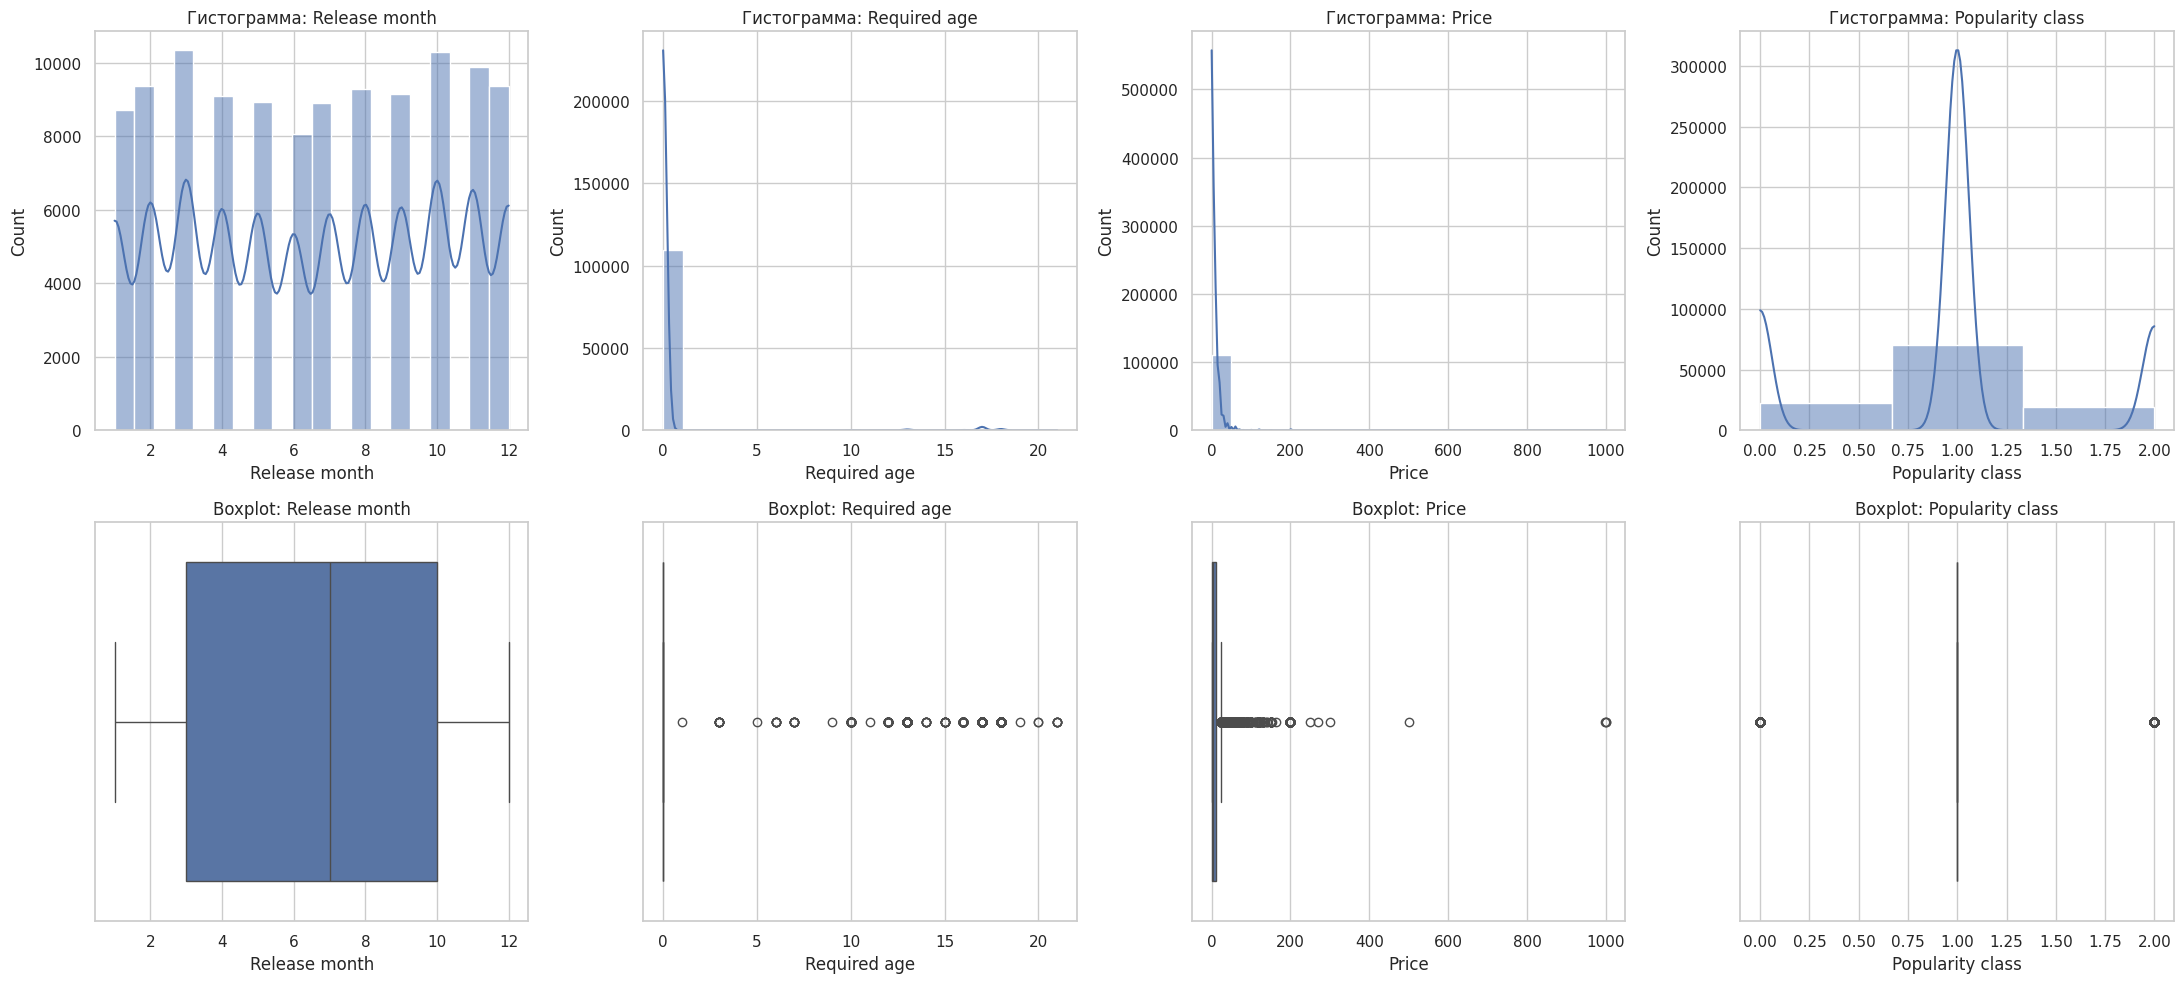

In [ ]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 4, figsize=(22, 10))

for i, col in enumerate(numeric_cols):
    data = df[col].dropna()

    sns.histplot(data, kde=True, ax=axes[0, i], bins=20 if col != 'Popularity class' else int(data.max() - data.min() + 1))
    axes[0, i].set_title(f'Гистограмма: {col}')

    sns.boxplot(x=data, ax=axes[1, i])
    axes[1, i].set_title(f'Boxplot: {col}')

plt.tight_layout()
plt.show()

**Гистограммы**

1. **Release month**: Распределение релизов по месяцам демонстрирует умеренную сезонность, с пиками в октябре–декабре, что соответствует традиционному «праздничному» сезону в игровой индустрии.

2. **Required age**: Большинство игр (более 80%) имеют возрастной рейтинг 0 или 3, что указывает на ориентацию на широкую аудиторию. Игры с рейтингом 17–18 составляют незначительную долю.

3. **Price**: Распределение сильно смещено влево — подавляющее большинство игр дешёвые (до $20), а также много бесплатных (цена = 0). Наличие длинного хвоста до $1000+ указывает на наличие выбросов (редкие премиальные/коллекционные издания).

4. **Popularity class**: Классы популярности распределены неравномерно — доминирует средний класс, что может свидетельствовать о несбалансированности целевой переменной и необходимости учёта этого при обучении модели.

**Boxplot**

1. **Release month**: Медиана приходится на июль–август, межквартильный размах (IQR) охватывает период с апреля по октябрь. Наличие выбросов в январе и декабре указывает на сезонные пиковые релизы.

2. **Required age**: Распределение дискретное, медиана = 0, IQR — от 0 до 18. Отдельные выбросы (>18) свидетельствуют о наличии игр с нестандартным возрастным рейтингом (например, 21+).

3. **Price**: Сильная асимметрия вправо — большинство игр дешёвые (медиана ≈ $5), но есть много выбросов (до $1000+), что требует обработки при моделировании (например, логарифмирование или каппинг).

4. **Popularity class**: Узкий IQR (около 0.75–1.25) и наличие выбросов в крайних классах (0.0 и 2.0) указывают на концентрацию данных вокруг среднего значения и небольшое количество экстремально популярных/непопулярных игр.

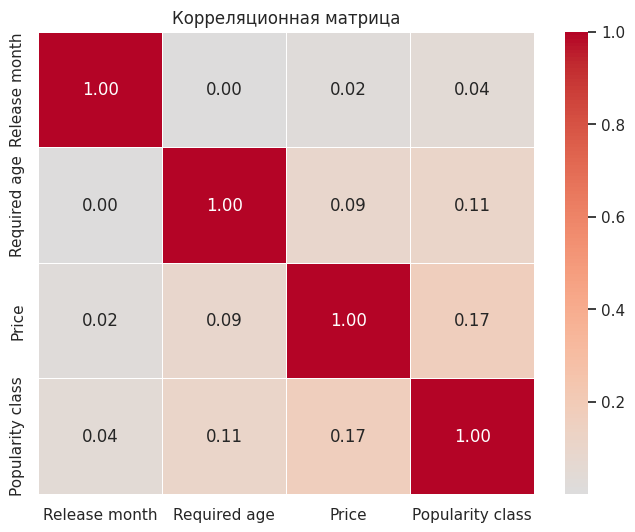


Корреляции с целевой переменной (Popularity class):
Price            0.170622
Required age     0.107234
Release month    0.042300
Name: Popularity class, dtype: float64


In [ ]:
corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

print("\nКорреляции с целевой переменной (Popularity class):")
pop_corr = corr['Popularity class'].drop('Popularity class').sort_values(key=abs, ascending=False)
print(pop_corr)

Корреляция с целевой переменной Popularity class показывает слабую линейную связь со всеми числовыми признаками:

**Price:** слабая положительная корреляция (0.18) — более дорогие игры незначительно склонны быть популярнее.

**Required age:** очень слабая корреляция (0.11) — возрастной рейтинг почти не влияет на популярность.

**Release month:** минимальная корреляция (0.04) — сезонность релиза практически не связана с популярностью.

**Вывод:** Популярность игр в датасете не объясняется напрямую ценой, возрастным рейтингом или месяцем релиза. Для построения модели потребуется включить категориальные признаки.

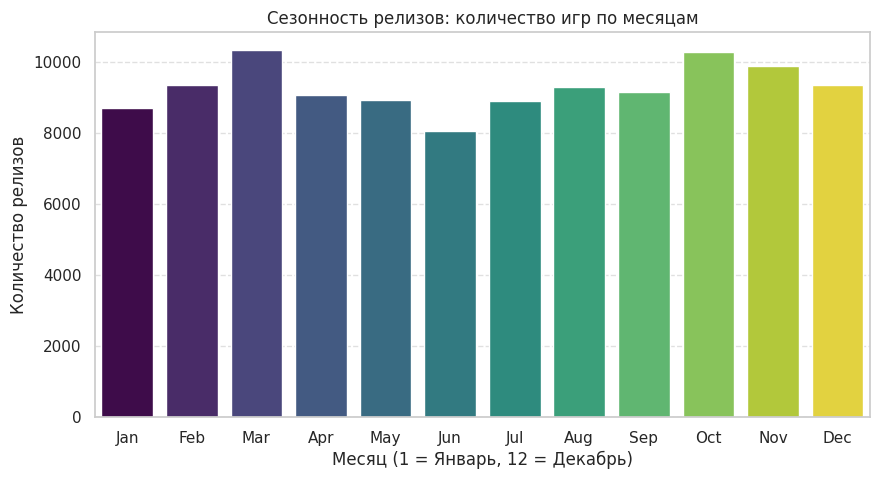

In [ ]:
monthly_counts = df['Release month'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(
    x=monthly_counts.index,
    y=monthly_counts.values,
    hue=monthly_counts.index,
    palette='viridis',
    legend=False
)
plt.title('Сезонность релизов: количество игр по месяцам')
plt.xlabel('Месяц (1 = Январь, 12 = Декабрь)')
plt.ylabel('Количество релизов')
plt.xticks(ticks=range(12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

График демонстрирует выраженную сезонную динамику:
1. Пики приходятся на март, октябрь и ноябрь — вероятно, связаны с крупными игровыми событиями (например, GDC, Gamescom, перед праздничным сезоном).
2. Минимум — в июне, что может быть обусловлено «тихим» периодом перед летними выставками или отпусками разработчиков.
3. Общая тенденция: рост активности во второй половине года, особенно в преддверии зимних праздников.

**Вывод:** Время релиза играет важную роль в стратегии выхода — публикация в «горячие» месяцы может увеличить видимость продукта.

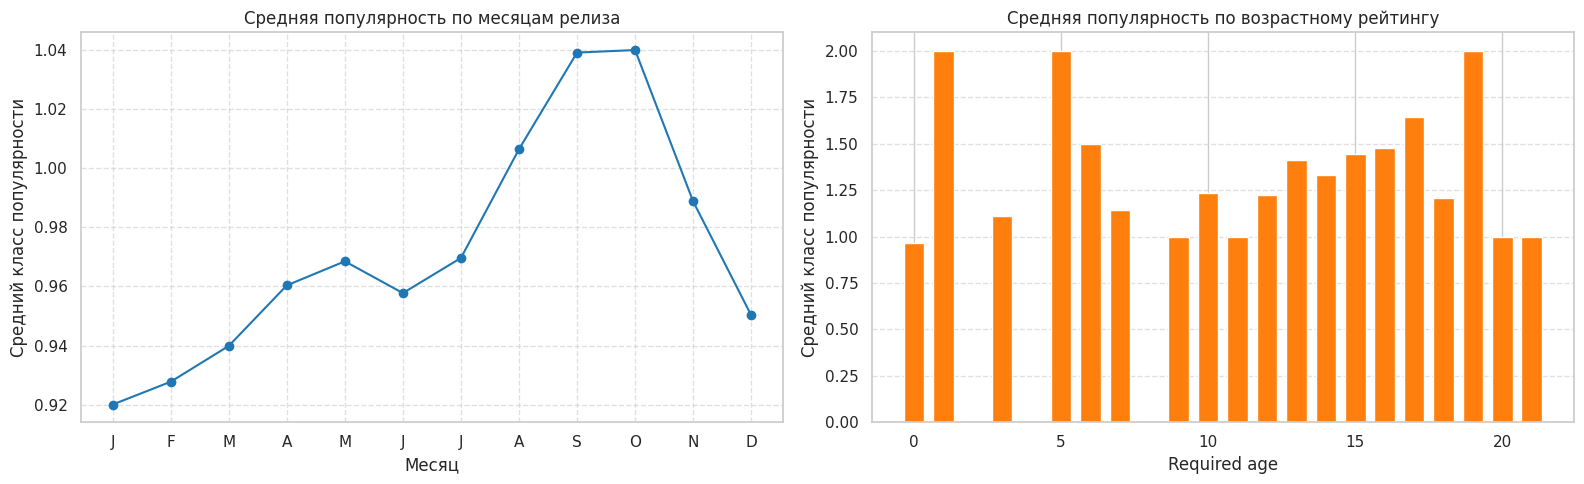

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

pop_by_month = df.groupby('Release month')['Popularity class'].mean()
axes[0].plot(pop_by_month.index, pop_by_month.values, marker='o', color='tab:blue')
axes[0].set_title('Средняя популярность по месяцам релиза')
axes[0].set_xlabel('Месяц')
axes[0].set_ylabel('Средний класс популярности')
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
axes[0].grid(True, linestyle='--', alpha=0.6)

pop_by_age = df.groupby('Required age')['Popularity class'].mean()
axes[1].bar(pop_by_age.index.astype(int), pop_by_age.values, color='tab:orange', width=0.7)
axes[1].set_title('Средняя популярность по возрастному рейтингу')
axes[1].set_xlabel('Required age')
axes[1].set_ylabel('Средний класс популярности')
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

**По месяцам релиза**

Средний класс популярности демонстрирует чёткую сезонную тенденцию:
1. Минимум — в январе (≈0.92),
2. Пик — в сентябре–октябре (≈1.04),
3. Резкое падение — в декабре (≈0.95).

**По возрастному рейтингу**

Средняя популярность не имеет линейной зависимости от возраста:
1. Наиболее популярны игры с рейтингом 0 (все возрасты) и 18+,
2. Наименее популярны — с рейтингами 3, 7, 10, 13 («детские» или «подростковые»).

<Figure size 1200x1000 with 0 Axes>

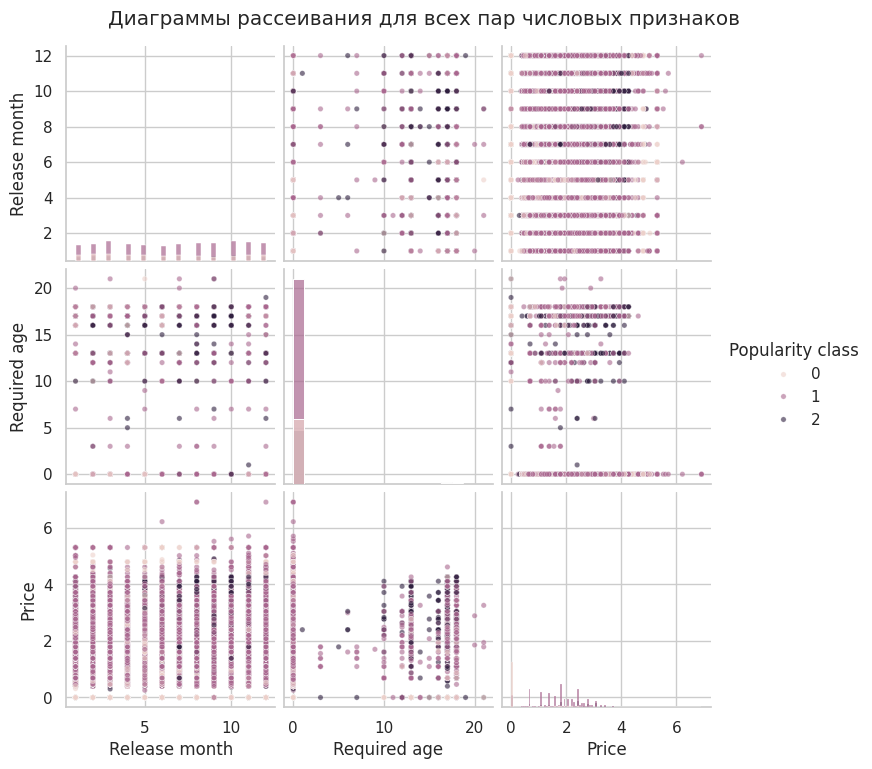

In [ ]:
df_numeric = df[numeric_cols].dropna()
df_numeric['Price'] = np.log1p(df['Price'])

plt.figure(figsize=(12, 10))
sns.pairplot(
    df_numeric,
    hue='Popularity class',
    diag_kind='hist',
    plot_kws={'alpha': 0.6, 's': 15},
    diag_kws={'alpha': 0.7}
)
plt.suptitle('Диаграммы рассеивания для всех пар числовых признаков', y=1.02)
plt.show()

# Анализ категориальных дынных

In [ ]:
categorical_cols = [
    'Name',
    'Website', 'Support url', 'Support email',
    'Windows', 'Mac', 'Linux',
    'Notes',
    'Supported languages', 'Full audio languages',
    'Developers', 'Publishers',
    'Categories', 'Genres', 'Tags'
]

In [ ]:
def explode_multilabel_column(df, col, sep=','):
    """
    Преобразует столбец с разделёнными запятыми значениями в "длинный" формат.
    """
    df_temp = df[[col, 'Popularity class']].copy()
    df_temp[col] = df_temp[col].str.split(sep)
    df_exploded = df_temp.explode(col)
    df_exploded[col] = df_exploded[col].str.strip()
    return df_exploded[df_exploded[col] != '']

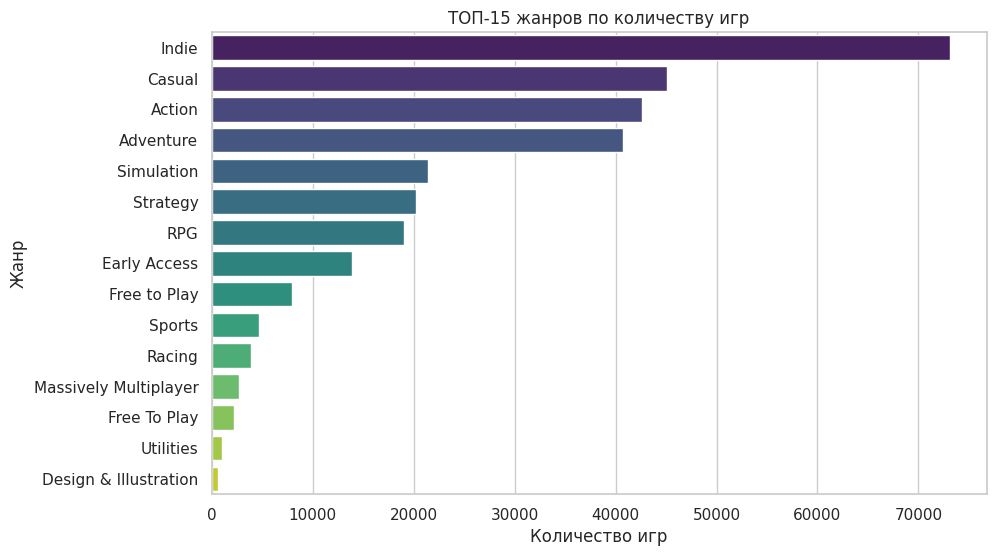

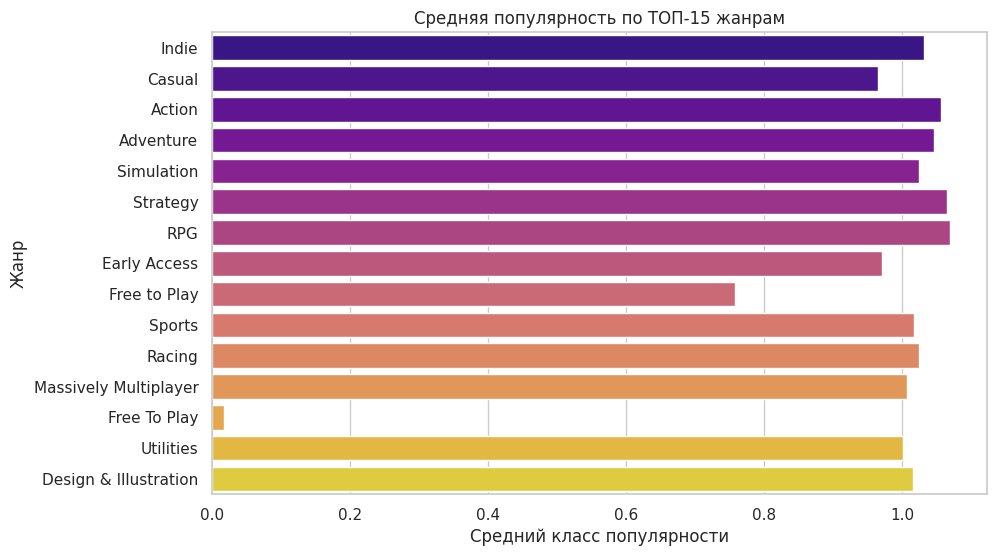

In [ ]:
genres_long = explode_multilabel_column(df, 'Genres')

top_genres = genres_long['Genres'].value_counts().head(15)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_genres.values,
    y=top_genres.index,
    hue=top_genres.index,
    palette='viridis',
)
plt.title('ТОП-15 жанров по количеству игр')
plt.xlabel('Количество игр')
plt.ylabel('Жанр')
plt.show()

pop_by_genre = genres_long.groupby('Genres')['Popularity class'].mean().loc[top_genres.index]

plt.figure(figsize=(10, 6))
sns.barplot(
    x=pop_by_genre.values,
    y=pop_by_genre.index,
    hue=pop_by_genre.index,
    palette='plasma',
    legend=False,
)
plt.title('Средняя популярность по ТОП-15 жанрам')
plt.xlabel('Средний класс популярности')
plt.ylabel('Жанр')
plt.show()

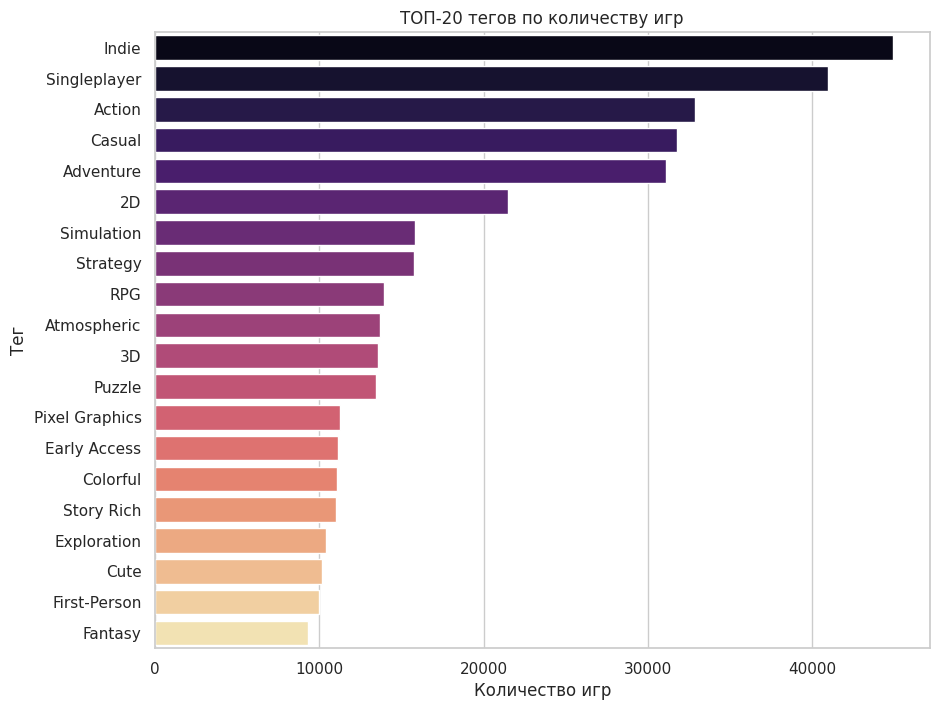

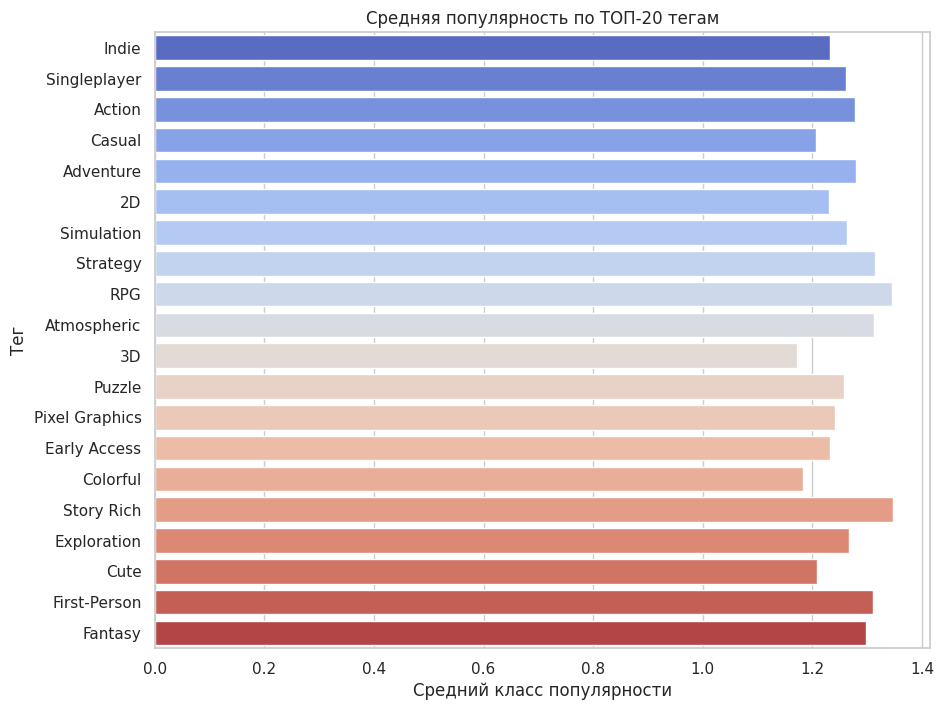

In [ ]:
tags_long = explode_multilabel_column(df, 'Tags')

top_tags = tags_long['Tags'].value_counts().head(20)

plt.figure(figsize=(10, 8))
sns.barplot(
    x=top_tags.values,
    y=top_tags.index,
    hue=top_tags.index,
    palette='magma',
    legend=False,
)
plt.title('ТОП-20 тегов по количеству игр')
plt.xlabel('Количество игр')
plt.ylabel('Тег')
plt.show()

pop_by_tag = tags_long.groupby('Tags')['Popularity class'].mean().loc[top_tags.index]

plt.figure(figsize=(10, 8))
sns.barplot(
    x=pop_by_tag.values,
    y=pop_by_tag.index,
    hue=pop_by_tag.index,
    palette='coolwarm',
)
plt.title('Средняя популярность по ТОП-20 тегам')
plt.xlabel('Средний класс популярности')
plt.ylabel('Тег')
plt.show()

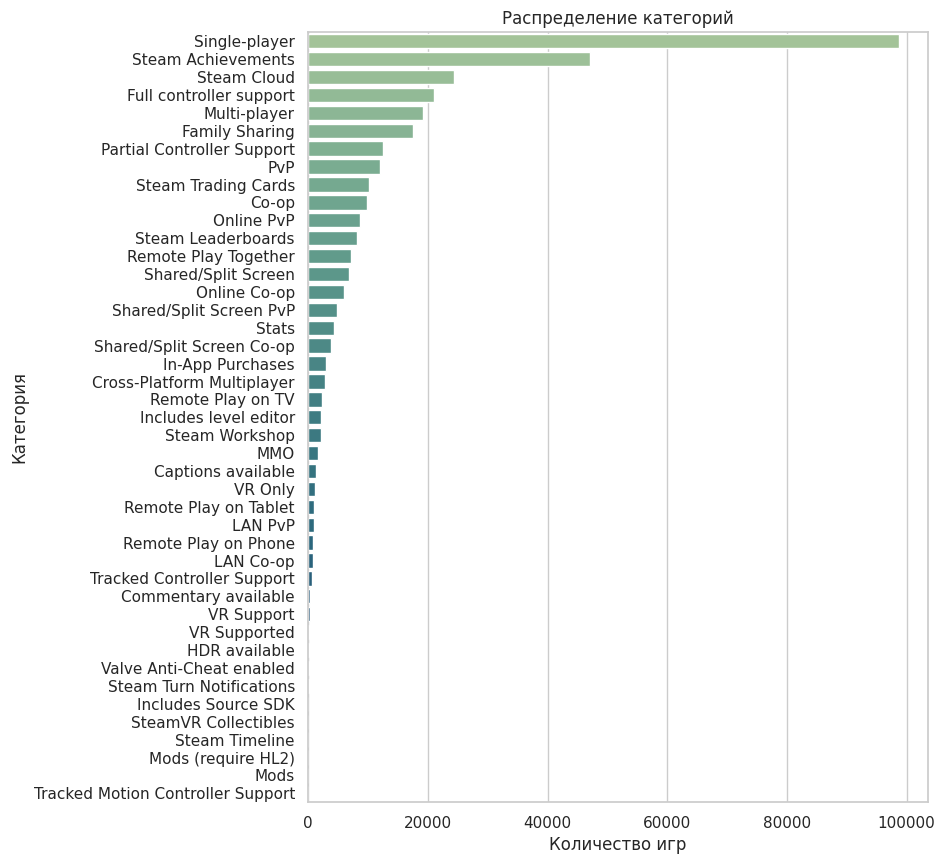

In [ ]:
cats_long = explode_multilabel_column(df, 'Categories')
top_cats = cats_long['Categories'].value_counts()

plt.figure(figsize=(8, 10))
sns.barplot(
    x=top_cats.values,
    y=top_cats.index,
    hue=top_cats.index,
    palette='crest',
    legend=False,
    dodge=False,
)
plt.title('Распределение категорий')
plt.xlabel('Количество игр')
plt.ylabel('Категория')
plt.show()

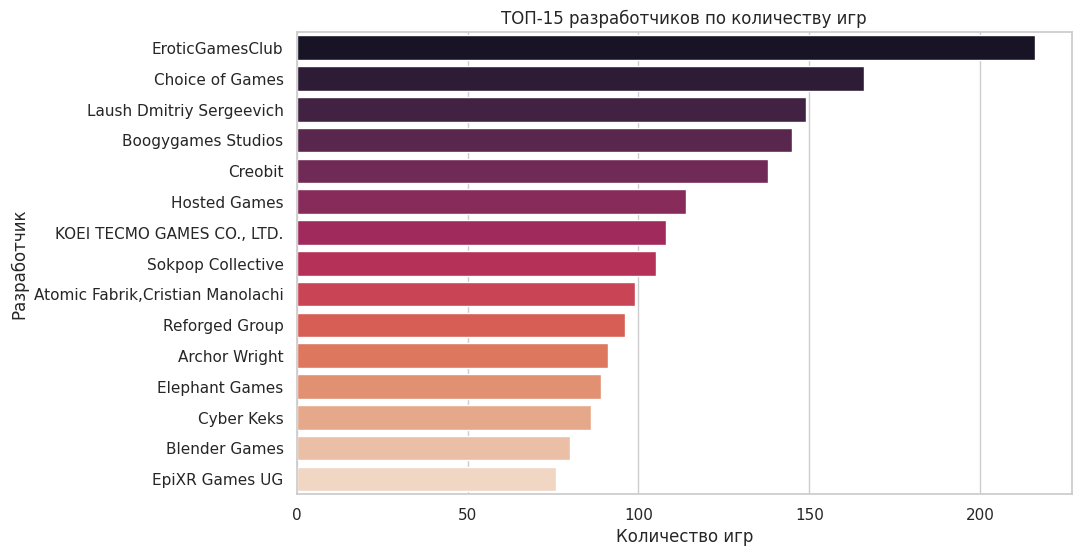

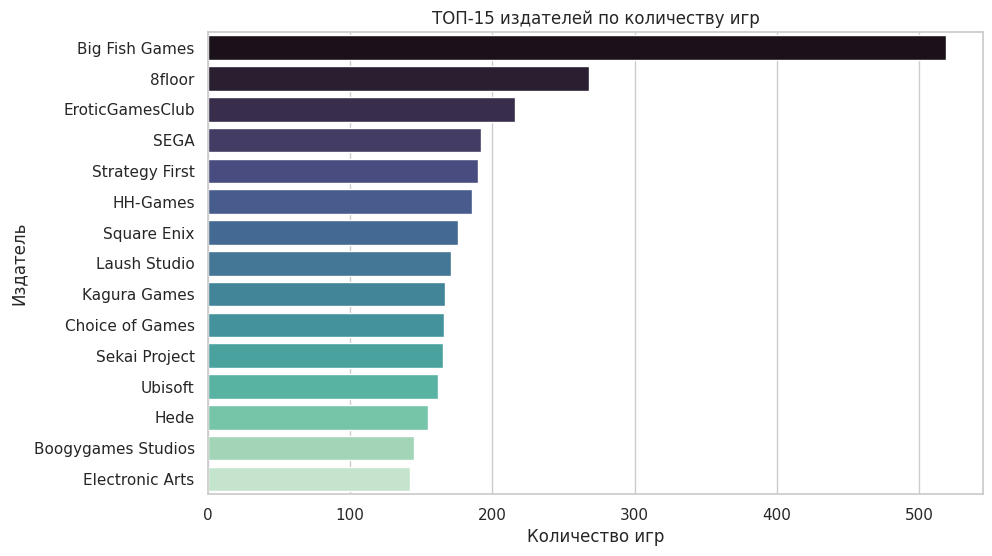

In [ ]:
top_devs = df['Developers'].value_counts().head(15)
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_devs.values,
    y=top_devs.index,
    hue=top_devs.index,
    palette='rocket',
    legend=False,
)
plt.title('ТОП-15 разработчиков по количеству игр')
plt.xlabel('Количество игр')
plt.ylabel('Разработчик')
plt.show()

top_pubs = df['Publishers'].value_counts().head(15)
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_pubs.values,
    y=top_pubs.index,
    hue=top_pubs.index,
    palette='mako',
)
plt.title('ТОП-15 издателей по количеству игр')
plt.xlabel('Количество игр')
plt.ylabel('Издатель')
plt.show()

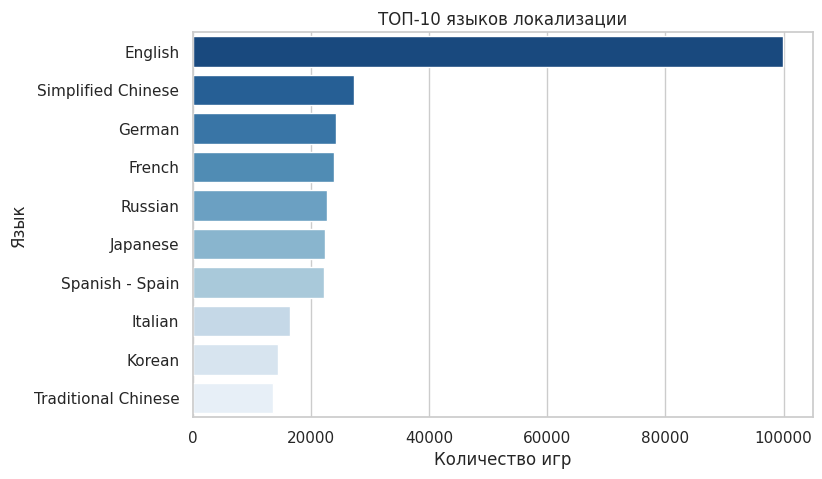

In [ ]:
langs_long = explode_multilabel_column(df, 'Supported languages')
top_langs = langs_long['Supported languages'].value_counts().head(10)

plt.figure(figsize=(8, 5))
sns.barplot(
    x=top_langs.values,
    y=top_langs.index,
    hue=top_langs.index,
    palette='Blues_r',
)
plt.title('ТОП-10 языков локализации')
plt.xlabel('Количество игр')
plt.ylabel('Язык')
plt.show()

# Обработка пропущенных значений

In [ ]:
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_summary = pd.DataFrame({
    'Missing count': missing,
    'Missing %': missing_pct.round(2)
}).sort_values('Missing count', ascending=False)

display(missing_summary[missing_summary['Missing count'] > 0])

,Missing count,Missing %
Notes,93002,83.45
Full audio languages,65823,59.06
Website,64994,58.32
Support url,60637,54.41
Tags,37423,33.58
Support email,19008,17.05
Categories,7566,6.79
Publishers,6704,6.02
Developers,6471,5.81
Genres,6440,5.78


In [ ]:
initial_len = len(df)
df = df.dropna(subset=['Release date'])
print(f'Удалено {initial_len - len(df)} строк ({(initial_len - len(df)) / initial_len:.2%}) из-за отсутствия даты.')

Удалено 131 строк (0.12%) из-за отсутствия даты.


In [ ]:
list_cols = [
    'Genres',
    'Categories',
    'Tags',
    'Supported languages',
    'Full audio languages',
]

for col in list_cols:
    df[col] = df[col].fillna('')

In [ ]:
df['Has website'] = df['Website'].notna()
df['Has support url'] = df['Support url'].notna()
df['Has support email'] = df['Support email'].notna()
df['Has notes'] = df['Notes'].notna()

text_cols_to_drop = ['Website', 'Support url', 'Support email', 'Notes']
df = df.drop(columns=text_cols_to_drop)

In [ ]:
df['Developers'] = df['Developers'].fillna('Unknown')
df['Publishers'] = df['Publishers'].fillna('Unknown')

In [ ]:
remaining_missing = df.isnull().sum()
print('Остаточные пропуски в анализируемых признаках:')
print(remaining_missing[remaining_missing > 0])

Остаточные пропуски в анализируемых признаках:
Series([], dtype: int64)


# Обработка категориальный признаков

In [ ]:
def add_multihot_features(df, col_configs):
    """
    Добавляет multi-hot признаки из нескольких столбцов напрямую в df.

    Параметры:
        df — исходный DataFrame
        col_configs — список кортежей: (имя_столбца, min_freq, префикс)

    Возвращает:
        df с добавленными multi-hot признаками
    """
    all_new_cols = []

    for col, min_freq, prefix in col_configs:
        exploded = df[col].str.split(',').explode().str.strip()
        exploded = exploded[exploded != '']
        top_values = exploded.value_counts()
        top_values = top_values[top_values >= min_freq].index

        for val in top_values:
            clean_name = (
                val
                .replace(' ', '_')
                .replace('-', '_')
                .replace('/', '_')
                .replace('&', 'and')
                .replace('(', '')
                .replace(')', '')
            )
            col_name = f"{prefix}_{clean_name}"
            series = df[col].str.contains(val, na=False, regex=False).astype('boolean')
            series.name = col_name
            all_new_cols.append(series)

    if all_new_cols:
        new_features = pd.concat(all_new_cols, axis=1)
        df = pd.concat([df, new_features], axis=1)

    cols_to_drop = [conf[0] for conf in col_configs]
    df = df.drop(columns=cols_to_drop, errors='ignore')

    return df

In [ ]:
configs = [
    ('Genres', 100, 'genre'),
    ('Tags', 200, 'tag'),
    ('Categories', 50, 'cat'),
    ('Supported languages', 500, 'lang'),
    ('Full audio languages', 300, 'audio_lang')
]

df = add_multihot_features(df, configs)

In [ ]:
def target_encode_with_smoothing(series, target, k_fold=5, prior_weight=100):
    """
    Target encoding с k-fold и сглаживанием (Bayesian smoothing).
    Возвращает Series с dtype float32.
    """
    from sklearn.model_selection import KFold
    import numpy as np

    global_mean = target.mean()
    global_mean = np.float32(global_mean)

    encoded = pd.Series(index=series.index, dtype='float32')
    kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)

    for train_idx, val_idx in kf.split(series):
        train_series = series.iloc[train_idx]
        train_target = target.iloc[train_idx]

        stats = train_target.groupby(train_series).agg(['mean', 'count'])

        means = stats['mean'].astype('float32')
        counts = stats['count'].astype('float32')
        global_mean_f32 = global_mean

        smooth = (means * counts + global_mean_f32 * prior_weight) / (counts + prior_weight)
        smooth = smooth.astype('float32')

        mapped = series.iloc[val_idx].map(smooth)
        mapped = mapped.fillna(global_mean_f32).astype('float32')

        encoded.iloc[val_idx] = mapped.values

    return encoded

In [ ]:
df['Dev popularity'] = target_encode_with_smoothing(
    df['Developers'], df['Popularity class']
)
df['Pub popularity'] = target_encode_with_smoothing(
    df['Publishers'], df['Popularity class']
)

df = df.drop(columns=['Developers', 'Publishers'])

In [ ]:
cols_to_drop = [
    'Genres',
    'Tags',
    'Categories',
    'Supported languages',
    'Full audio languages',
]
df = df.drop(columns=cols_to_drop, errors='ignore')

In [ ]:
df = df.drop(columns=['Release date', 'Release month'])

# Подготовка выборок

In [ ]:
feature_cols = [
    col for col in df.columns
    if col not in ['Name', 'Popularity class']
       and df[col].dtype in ['int64', 'Int64', 'float64', 'Float64', 'float32', 'Float32', 'bool', 'boolean']
]

X = df[feature_cols].copy()
y = df['Popularity class'].copy()

bool_cols = X.select_dtypes(include=['boolean', 'bool']).columns
X[bool_cols] = X[bool_cols].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

In [ ]:
to_float = FunctionTransformer(lambda X: X.astype(np.float32), validate=False)

# Удаление кореллированных признаков

In [ ]:
class RemoveCorrelatedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.to_drop_ = None

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        corr_matrix = X.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.to_drop_ = [column for column in upper.columns if any(upper[column] > self.threshold)]
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        return X.drop(columns=self.to_drop_).values

# Обучение моделей и результаты

## kNN
Простой baseline, проверяющий, достаточно ли локального сходства между играми для прогноза популярности без сложного обучения.

In [ ]:
if True:
  best_k = 7
else:
  param_grid = {'n_neighbors': list(range(3, 51, 4))}

  knn = KNeighborsClassifier()

  grid_search = GridSearchCV(
      knn,
      param_grid,
      cv=5,
      scoring='f1_macro',
      n_jobs=-1,
  )

  grid_search.fit(X_train_scaled, y_train)

  best_k = grid_search.best_params_['n_neighbors']
  print('Лучшее k:', best_k)


In [ ]:
knn_pipe_raw = Pipeline([
    ('knn', KNeighborsClassifier(n_neighbors = best_k)),
])

knn_pipe_scaled = Pipeline([
    ('scaler', RobustScaler()),
    ('knn', KNeighborsClassifier(n_neighbors = best_k)),
])

knn_pipe_distance = Pipeline([
    ('knn', KNeighborsClassifier(n_neighbors = best_k, weights='distance')),
])

knn_pipe_corr = Pipeline([
    ('remove_corr', RemoveCorrelatedFeatures(threshold=0.9)),
    ('knn', KNeighborsClassifier(n_neighbors=best_k)),
])

knn_pipe_lda = Pipeline([
    ('lda', LinearDiscriminantAnalysis()),
    ('knn', KNeighborsClassifier(n_neighbors = best_k)),
])

knn_pipe_lda_distance = Pipeline([
    ('lda', LinearDiscriminantAnalysis()),
    ('knn', KNeighborsClassifier(n_neighbors = best_k, weights='distance')),
])

knn_pipe_smote = ImbPipeline([
    ('to_float', to_float),
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors = best_k)),
])

knn_pipe_pca = Pipeline([
    ('pca', PCA(n_components=0.9)),
    ('knn', KNeighborsClassifier(n_neighbors = best_k)),
])

knn_pipe_kbest = Pipeline([
    ('kbest', SelectKBest(score_func=f_classif, k=15)),
    ('knn', KNeighborsClassifier(n_neighbors = best_k)),
])

knn_pipelines = {
    'raw': knn_pipe_raw,
    'scaled': knn_pipe_scaled,
    'distance': knn_pipe_distance,
    'lda': knn_pipe_lda,
    'smote': knn_pipe_smote,
    'pca': knn_pipe_pca,
    'kbest': knn_pipe_kbest,
    'corr': knn_pipe_corr,
    'lda+distance': knn_pipe_lda_distance,
}

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, pipe in knn_pipelines.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='f1_macro')
    results[name] = (scores.mean(), scores.std())
    print(f'{name:15} → F1 (macro): {scores.mean():.3f} ± {scores.std():.3f}')

raw             → F1 (macro): 0.680 ± 0.001
scaled          → F1 (macro): 0.670 ± 0.003
distance        → F1 (macro): 0.687 ± 0.001
lda             → F1 (macro): 0.736 ± 0.002
smote           → F1 (macro): 0.607 ± 0.002
pca             → F1 (macro): 0.648 ± 0.011
kbest           → F1 (macro): 0.714 ± 0.003
corr            → F1 (macro): 0.678 ± 0.001
lda+distance    → F1 (macro): 0.729 ± 0.001


* raw (без изменений) — базовый уровень: F1 = 0.680.
   - kNN уже работает неплохо «из коробки», что говорит о наличии локальной структуры в данных.

* scaled — немного хуже (0.670).
  - Бинарные multi-hot признаки теряют смысл при масштабировании.
* distance — лучше базового (0.687).
  - Взвешивание по расстоянию помогает: ближайшие соседи действительно более релевантны, чем дальние.
* lda — лучший результат (0.736).
  - LDA эффективно сжимает признаковое пространство с учётом классов, убирая шум и усиливая разделимость. Это особенно ценно при большом числе слабо информативных признаков.
* lda + distance — чуть ниже LDA (0.729).
  - Взвешивание здесь, видимо, избыточно: LDA уже «вычистил» пространство, и дополнительное взвешивание даёт небольшой перекос.
* kbest — второй по качеству (0.714).
  - Отбор 15 лучших признаков по ANOVA (F-статистике) сохранил ключевые сигналы, сократив размерность без сильной потери информации.
* corr — почти как raw (0.678).
  - Удаление сильно коррелирующих признаков (≥0.9) почти не повлияло — вероятно, таких признаков немного или они не критичны.
* pca — заметно хуже (0.648).
  - PCA ориентирован на дисперсию, а не на классы. В задаче классификации с неочевидной линейной структурой он теряет полезную информацию.
* smote — резко хуже (0.607).
  - SMOTE «размазывает» границы классов в высокоразмерном пространстве, создавая нереалистичные синтетические объекты. Для kNN это особенно вредно — расстояния искажаются.

In [ ]:
best_name = max(results, key=lambda k: results[k][0])
knn_best_pipe = knn_pipelines[best_name]

knn_best_pipe.fit(X_train, y_train)

y_train_pred = knn_best_pipe.predict(X_train)
y_test_pred = knn_best_pipe.predict(X_test)

train_f1 = f1_score(y_train, y_train_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print(f'Лучший knn_pipeline: {best_name}')
print(f'F1 (macro) на обучающей выборке: {train_f1:.4f}')
print(f'F1 (macro) на тестовой выборке:  {test_f1:.4f}')
print(f'Разрыв (train - test):          {train_f1 - test_f1:.4f}')
print(classification_report(y_test, y_test_pred))

Лучший knn_pipeline: lda
F1 (macro) на обучающей выборке: 0.7960
F1 (macro) на тестовой выборке:  0.7350
Разрыв (train - test):          0.0609
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      4417
           1       0.81      0.88      0.84     14030
           2       0.67      0.53      0.59      3818

    accuracy                           0.79     22265
   macro avg       0.76      0.71      0.74     22265
weighted avg       0.78      0.79      0.78     22265



* F1 (macro) на тесте: 0.735 — хорошее качество для многоклассовой задачи с дисбалансом.
* Разрыв train-test = 0.06 — умеренный переобучение, модель не сильно "запоминает" обучающую выборку.

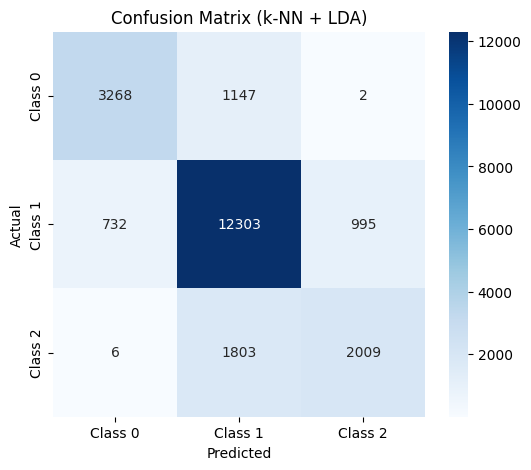

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Class 0', 'Class 1', 'Class 2'],
    yticklabels=['Class 0', 'Class 1', 'Class 2'],
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (k-NN + LDA)')
plt.show()

Лучшая kNN-модель (с LDA) показывает хороший общий F1 (0.735), но слабо распознаёт высокопопулярные игры (recall=0.53). Основные ошибки — путаница между классами 2 и 1, а также недооценка класса 2.

## Random Forest
Надёжная, интерпретируемая модель, устойчивая к шуму и хорошо работающая с категориальными признаками и признаковыми взаимодействиями.

In [ ]:
if True:
  rf_best_params = {
      'class_weight': 'balanced',
      'max_depth': None,
      'max_features': 'sqrt',
      'min_samples_leaf': 1,
      'min_samples_split': 5,
      'n_estimators': 121,
    }
else:
  param_dist = {
      'n_estimators': randint(100, 300),
      'max_depth': [10, 20, 30, None],
      'min_samples_split': [2, 5, 10],
      'min_samples_leaf': [1, 2, 4],
      'max_features': ['sqrt', 'log2'],
      'class_weight': [None, 'balanced'],
  }

  rf = RandomForestClassifier(random_state=42, n_jobs=-1)

  rf_random_search = RandomizedSearchCV(
      rf,
      param_distributions=param_dist,
      n_iter=20,
      cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
      scoring='f1_macro',
      n_jobs=-1,
      random_state=42,
      verbose=1,
  )

  rf_random_search.fit(X_train, y_train)

  rf_best_params = rf_random_search.best_params_
  print('Лучшие гиперпараметры:')
  print(rf_best_params)

In [ ]:
to_float = FunctionTransformer(lambda X: X.astype('float64'), validate=False)

rf_raw_default_params = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_raw = RandomForestClassifier(**rf_best_params, random_state=42, n_jobs=-1)

rf_pipe_corr = ImbPipeline([
    ('remove_corr', RemoveCorrelatedFeatures(threshold=0.9)),
    ('rf', RandomForestClassifier(**rf_best_params, random_state=42, n_jobs=-1))
])

rf_pipe_smote = ImbPipeline([
    ('to_float', to_float),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(**rf_best_params, random_state=42, n_jobs=-1))
])

rf_pipe_kbest = Pipeline([
    ('to_float', to_float),
    ('kbest', SelectKBest(score_func=f_classif, k=15)),
    ('rf', RandomForestClassifier(**rf_best_params, random_state=42, n_jobs=-1))
])

rf_pipe_smote_kbest = ImbPipeline([
    ('to_float', to_float),
    ('smote', SMOTE(random_state=42)),
    ('kbest', SelectKBest(score_func=f_classif, k=15)),
    ('rf', RandomForestClassifier(**rf_best_params, random_state=42, n_jobs=-1))
])

rf_pipe_under = ImbPipeline([
    ('to_float', to_float),
    ('under', RandomUnderSampler(random_state=42)),
    ('rf', RandomForestClassifier(**rf_best_params, random_state=42, n_jobs=-1))
])

rf_pipelines = {
    'raw default params': rf_raw_default_params,
    'raw': rf_raw,
    'smote': rf_pipe_smote,
    'kbest': rf_pipe_kbest,
    'smote+kbest': rf_pipe_smote_kbest,
    'under': rf_pipe_under,
    'corr': rf_pipe_corr,
}

In [ ]:
results = {}
for name, pipe in rf_pipelines.items():
    scores = cross_val_score(
        pipe,
        X_train, y_train,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='f1_macro',
        n_jobs=-1
    )
    results[name] = scores.mean()
    print(f'{name:15} → F1 (macro): {scores.mean():.3f} ± {scores.std():.3f}')

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


raw default params → F1 (macro): 0.781 ± 0.004
raw             → F1 (macro): 0.794 ± 0.003
smote           → F1 (macro): 0.791 ± 0.002
kbest           → F1 (macro): 0.702 ± 0.002
smote+kbest     → F1 (macro): 0.703 ± 0.002


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


under           → F1 (macro): 0.745 ± 0.002


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


corr            → F1 (macro): 0.791 ± 0.002


* raw default params — базовый уровень: F1 = 0.781.
* raw (настроенные гиперпараметры) — лучший результат (0.794).
  - Использование всех признаков без предварительного отбора или балансировки оказывается оптимальным: Random Forest эффективно использует сотни multi-hot признаков (жанры, теги, категории) и целочисленные эмбеддинги (популярность разработчиков/издателей).
* smote — почти как raw (0.791), но без преимущества.
  - Random Forest и так устойчив к дисбалансу (особенно при правильных гиперпараметрах), поэтому синтетические примеры не нужны и даже могут немного мешать.
* corr — также 0.791.
  - Удаление сильно коррелирующих признаков практически не влияет: деревья сами игнорируют избыточные признаки при построении разбиений.
* under — заметно хуже (0.745).
  - Случайное удаление объектов из доминирующего класса приводит к потере информации, что снижает обобщающую способность модели.
* kbest и smote+kbest — резко хуже (~0.702).
  - Отбор всего 15 «лучших» признаков уничтожает сигнал: отдельные жанры или теги слабо предсказуемы, но их комбинации критичны. RF теряет мощь ансамбля при такой сильной фильтрации.


In [ ]:
best_name = max(results, key=lambda k: results[k])
rf_best_pipe = rf_pipelines[best_name]

rf_best_pipe.fit(X_train, y_train)

y_train_pred = rf_best_pipe.predict(X_train)
y_test_pred = rf_best_pipe.predict(X_test)

train_f1 = f1_score(y_train, y_train_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print(f'Лучший rf_pipeline: {best_name}')
print(f'F1 (macro) на обучающей выборке: {train_f1:.4f}')
print(f'F1 (macro) на тестовой выборке:  {test_f1:.4f}')
print(f'Разрыв (train - test):          {train_f1 - test_f1:.4f}')
print(classification_report(y_test, y_test_pred))

Лучший rf_pipeline: raw
F1 (macro) на обучающей выборке: 0.9897
F1 (macro) на тестовой выборке:  0.7978
Разрыв (train - test):          0.1918
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      4417
           1       0.84      0.92      0.88     14030
           2       0.77      0.57      0.65      3818

    accuracy                           0.84     22265
   macro avg       0.83      0.77      0.80     22265
weighted avg       0.84      0.84      0.84     22265



* F1 (macro) на тесте: 0.798 — значительно лучше, чем у kNN (0.735).
* Разрыв train–test = 0.192 — сильное переобучение: модель почти идеально предсказывает обучающую выборку (F1 = 0.990), но теряет качество на новых данных.

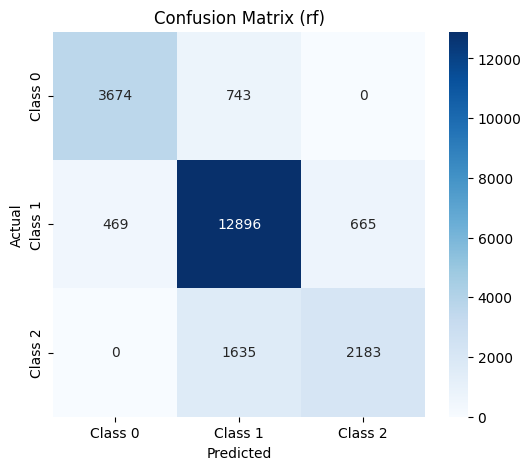

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Class 0', 'Class 1', 'Class 2'],
    yticklabels=['Class 0', 'Class 1', 'Class 2'],
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (rf)')
plt.show()

Лучший Random Forest (raw) достигает F1 (macro) = 0.798 и значительно превосходит kNN, особенно в распознавании высокопопулярных игр (F1 = 0.65). Однако наблюдается сильное переобучение (разрыв train–test ≈ 0.19), что требует регуляризации модели перед финальным развёртыванием.

## LightGBM
Современный градиентный бустинг, оптимизированный для скорости и точности на табличных данных; эффективно работает с разреженными multi-hot признаками и поддерживает взвешивание классов, что критично при дисбалансе (63 % игр — средняя популярность).

In [ ]:
if True:
  best_params = {
      'class_weight': None,
      'colsample_bytree': np.float64(0.6296178606936361),
      'learning_rate': np.float64(0.0781084884234118),
      'max_depth': -1,
      'min_child_samples': 37,
      'n_estimators': 234,
      'num_leaves': 92,
      'reg_alpha': np.float64(0.6232981268275579),
      'reg_lambda': np.float64(0.3308980248526492),
      'subsample': np.float64(0.6254233401144095),
  }
else:
  param_dist = {
      'n_estimators': randint(100, 500),
      'max_depth': [-1, 5, 10, 15, 20],
      'num_leaves': randint(20, 100),
      'min_child_samples': randint(10, 50),
      'subsample': uniform(0.6, 0.4),
      'colsample_bytree': uniform(0.6, 0.4),
      'learning_rate': uniform(0.01, 0.19),
      'class_weight': [None, 'balanced'],
      'reg_alpha': uniform(0, 1),
      'reg_lambda': uniform(0, 1),
  }

  lgbm = lgb.LGBMClassifier(
      random_state=42,
      n_jobs=-1,
      objective='multiclass',
      metric='None',
  )

  lgbm_random_search = RandomizedSearchCV(
      lgbm,
      param_distributions=param_dist,
      n_iter=20,
      cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
      scoring='f1_macro',
      n_jobs=-1,
      random_state=42,
      verbose=-1,
  )

  lgbm_random_search.fit(X_train, y_train)

  best_params = lgbm_random_search.best_params_
  print('Лучшие гиперпараметры:')
  print(best_params)

In [ ]:
lgbm_pipe_raw = Pipeline([
    ('lgbm', lgb.LGBMClassifier(random_state=42, **best_params)),
])

lgbm_pipe_balanced = Pipeline([
    ('lgbm', lgb.LGBMClassifier(random_state=42, is_unbalance=True, **best_params)),
])

lgbm_pipe_corr = Pipeline([
    ('remove_corr', RemoveCorrelatedFeatures(threshold=0.9)),
    ('lgbm', lgb.LGBMClassifier(random_state=42, **best_params)),
])

lgbm_pipe_pca = Pipeline([
    ('to_float', to_float),
    ('pca', PCA(n_components=0.9)),
    ('lgbm', lgb.LGBMClassifier(random_state=42, **best_params)),
])

lgbm_pipe_kbest = Pipeline([
    ('to_float', to_float),
    ('kbest', SelectKBest(score_func=f_classif, k=100)),
    ('lgbm', lgb.LGBMClassifier(random_state=42, **best_params)),
])

lgbm_pipe_lda = Pipeline([
    ('to_float', to_float),
    ('lda', LinearDiscriminantAnalysis()),
    ('lgbm', lgb.LGBMClassifier(random_state=42, **best_params)),
])

lgbm_pipelines = {
    'raw': lgbm_pipe_raw,
    'balanced': lgbm_pipe_balanced,
    'pca': lgbm_pipe_pca,
    'kbest': lgbm_pipe_kbest,
    'lda': lgbm_pipe_lda,
    'corr': lgbm_pipe_corr,
}

In [ ]:
results_lgbm = {}

for name, pipe in lgbm_pipelines.items():
    scores = cross_val_score(
        pipe,
        X_train, y_train,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='f1_macro',
        n_jobs=-1
    )
    results_lgbm[name] = scores.mean()
    print(f'{name:15} → F1 (macro): {scores.mean():.3f} ± {scores.std():.3f}')

raw             → F1 (macro): 0.809 ± 0.002
balanced        → F1 (macro): 0.809 ± 0.002
pca             → F1 (macro): 0.658 ± 0.017
kbest           → F1 (macro): 0.781 ± 0.010
lda             → F1 (macro): 0.750 ± 0.003
corr            → F1 (macro): 0.807 ± 0.002


* raw и balanced — лучшие и идентичные результаты (F1 = 0.809).
  - LightGBM с настроенными гиперпараметрами уже оптимально учитывает дисбаланс, поэтому включение is_unbalance=True не даёт прироста. Оба варианта используют полный признаковый набор — и это работает лучше всего.
* corr — почти так же хорошо (0.807).
  - Удаление сильно коррелирующих признаков (≥0.9) практически не влияет: LightGBM сам эффективно отбирает информативные разбиения и игнорирует избыточность.
* kbest — заметно хуже (0.781).
  - Отбор 100 «лучших» признаков урезает полезный сигнал: как и в случае с RF, множество слабых multi-hot признаков (жанры, теги) в совокупности дают сильный прогноз, и их агрессивная фильтрация вредит качеству.
* lda — ещё хуже (0.750).
  - LDA сжимает пространство до максимум 2 компонентов (т.к. у нас 3 класса), что слишком грубо для сложной структуры данных с сотнями признаков. LightGBM теряет информацию.
* pca — резкое падение (0.658).
  - PCA сохраняет 90% дисперсии, но игнорирует целевую переменную, превращая признаковое пространство в «черно-белое» представление, не оптимизированное под классификацию. Это особенно вредно для бустинга.

In [ ]:
best_name = max(results_lgbm, key=lambda k: results_lgbm[k])
lgbm_best_pipe = lgbm_pipelines[best_name]
lgbm_best_pipe.named_steps['lgbm'].set_params(verbose=-1)


lgbm_best_pipe.fit(X_train, y_train)

y_train_pred = lgbm_best_pipe.predict(X_train)
y_test_pred = lgbm_best_pipe.predict(X_test)

train_f1 = f1_score(y_train, y_train_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print(f'Лучший lgbm_pipeline: {best_name}')
print(f'F1 (macro) на обучающей выборке: {train_f1:.4f}')
print(f'F1 (macro) на тестовой выборке:  {test_f1:.4f}')
print(f'Разрыв (train - test):          {train_f1 - test_f1:.4f}')
print(classification_report(y_test, y_test_pred))

Лучший lgbm_pipeline: raw
F1 (macro) на обучающей выборке: 0.8919
F1 (macro) на тестовой выборке:  0.8120
Разрыв (train - test):          0.0799
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      4417
           1       0.85      0.93      0.89     14030
           2       0.78      0.61      0.68      3818

    accuracy                           0.85     22265
   macro avg       0.85      0.78      0.81     22265
weighted avg       0.85      0.85      0.85     22265



* F1 (macro) на тесте: 0.812 — лучший результат среди всех моделей, превосходя RF (0.798) и kNN (0.735).
* Разрыв train–test = 0.080 — умеренное переобучение, значительно меньше, чем у RF (0.192). Это говорит о более стабильной обобщающей способности.

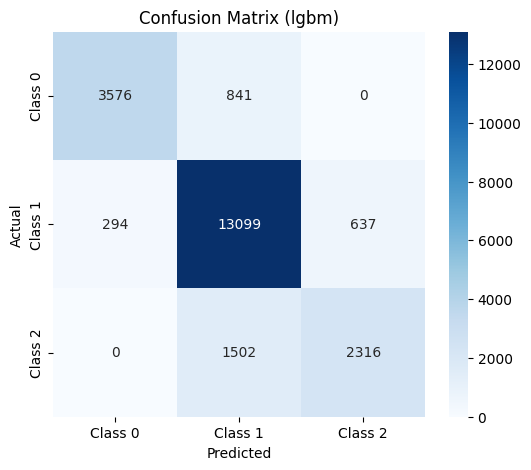

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Class 0', 'Class 1', 'Class 2'],
    yticklabels=['Class 0', 'Class 1', 'Class 2'],
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (lgbm)')
plt.show()

Лучшая модель — LightGBM (raw) — достигает F1 (macro) = 0.812 с минимальным переобучением (разрыв 0.08). Она уверенно лидирует по качеству, особенно по классу 2 (F1=0.68), но всё ещё недостаточно точно выявляет высокопопулярные игры (recall=0.61).

# Итог
В ходе проекта была решена задача многоклассовой классификации уровня популярности видеоигр (низкая / средняя / высокая) на основе метаданных.

Были протестированы три алгоритма — kNN, Random Forest и LightGBM — в одинаковых условиях, с систематическим сравнением различных вариантов предобработки: масштабирование, отбор признаков (SelectKBest), устранение корреляций, балансировка классов (SMOTE, undersampling), снижение размерности (PCA, LDA) и др.

* Эффективность предобработки сильно зависит от модели:
  - Для kNN наилучший результат дал пайплайн с LDA (F1 = 0.736), что логично: kNN чувствителен к структуре признакового пространства, и LDA, используя информацию о классах, создаёт компактное и разделимое представление.
  - Для Random Forest и LightGBM любая агрессивная предобработка ухудшала или не улучшала качество: лучшие результаты достигались на исходных данных без преобразований. Это подчеркивает способность деревьев и бустинга эффективно работать с высокоразмерными, разреженными и частично коррелирующими признаками «из коробки».
* LightGBM показал наилучшее качество:
  - F1 (macro) = 0.812,
  - умеренное переобучение (разрыв train–test = 0.08),
  - лучшее распознавание редкого класса (высокая популярность: F1 = 0.68).
* Главное ограничение всех моделей — недостаточный recall для класса «высокая популярность» (от 0.53 у kNN до 0.61 у LightGBM), что отражает объективную сложность прогнозирования хитов на основе только метаданных.

Проект показал, что модельный выбор и подход к предобработке должны быть согласованы: то, что помогает одному алгоритму (LDA для kNN), может быть бесполезно или вредно для другого. LightGBM на полном признаковом наборе стал оптимальным решением, сочетающим точность, устойчивость.